In [43]:
from utilities import *

raw_data = pd.read_excel("data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data[sa.brand35]
sa.excel(data, "data/data_GPT.xlsx")

### Firstly, we analyse the seasonality

To be able to do it, we need to filter data with a specific supermarket, variant, and pack size.

In [44]:
filter_data = data[
    (data["supermarket"] == "supermarket-A")
    & (data["variant"] == "standard")
    & (data["pack.size"] == "351 - 500 GR")
]

Check visualizations for seasonal patterns.

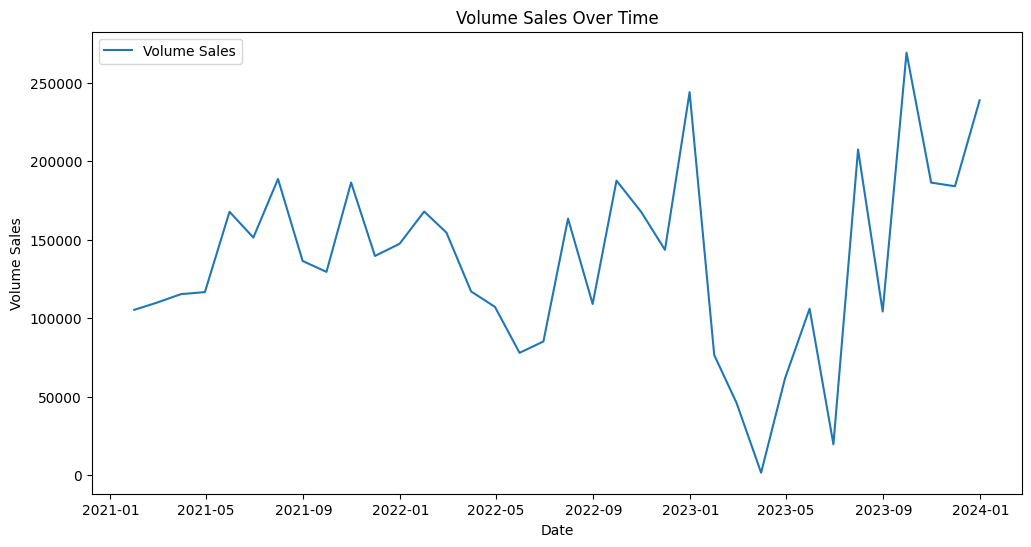

In [45]:
#plotting the time series to see if there is seasonality
plt.figure(figsize=(12, 6))
plt.plot(filter_data["date"], filter_data["volume.sales"], label="Volume Sales")
plt.xlabel("Date")
plt.ylabel("Volume Sales")
plt.title("Volume Sales Over Time")
plt.legend()
plt.show()

In theory, it seems we don't have seasonality
However, we are going to crop data in 3 parts to see if we can find any seasonal patterns

Data from 2021-01-31 to 2023-12-31
Crop 1 from 2021-01-31 to 2021-12-31
Crop 2 from 2022-01-31 to 2022-12-31
Crop 3 from 2023-01-31 to 2023-12-31


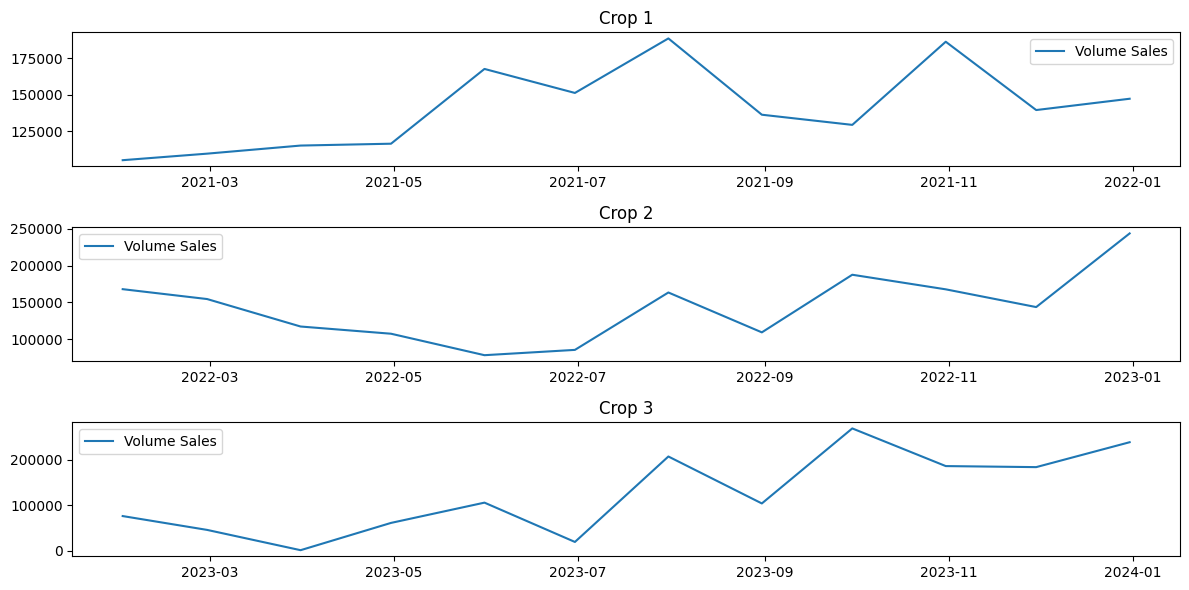

In [46]:
print("Data from {} to {}".format(filter_data["date"].min(), filter_data["date"].max()))
# print(filter_data.head())

#crop the data in 3 parts
size = int(len(filter_data) * 1/3)

crop1 = filter_data[:size]
crop2 = filter_data[size:2*size]
crop3 = filter_data[2*size:]

print("Crop 1 from {} to {}".format(crop1["date"].min(), crop1["date"].max()))
print("Crop 2 from {} to {}".format(crop2["date"].min(), crop2["date"].max()))
print("Crop 3 from {} to {}".format(crop3["date"].min(), crop3["date"].max()))

#plot the 3 crops
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(crop1["date"], crop1["volume.sales"], label="Volume Sales")
plt.title("Crop 1")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(crop2["date"], crop2["volume.sales"], label="Volume Sales")
plt.title("Crop 2")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(crop3["date"], crop3["volume.sales"], label="Volume Sales")
plt.title("Crop 3")
plt.legend()

plt.tight_layout()
plt.show()

The data seems to have an annual seasonality, which looks good. 

Later, we should use this info to select the optimum value of the parameter d.

#### We'll see seasonal decomposition, ACF, and PACF plots.

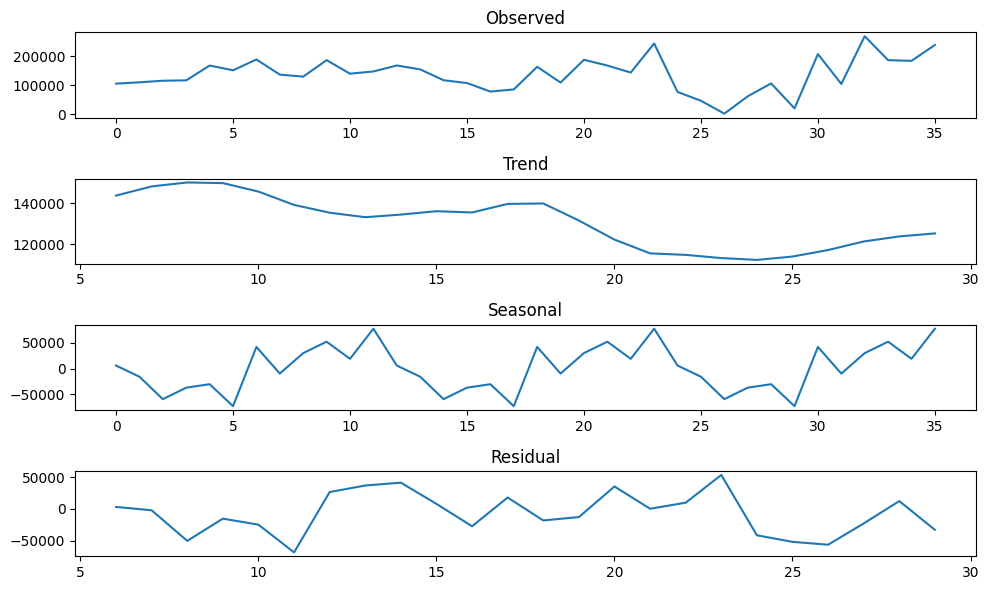

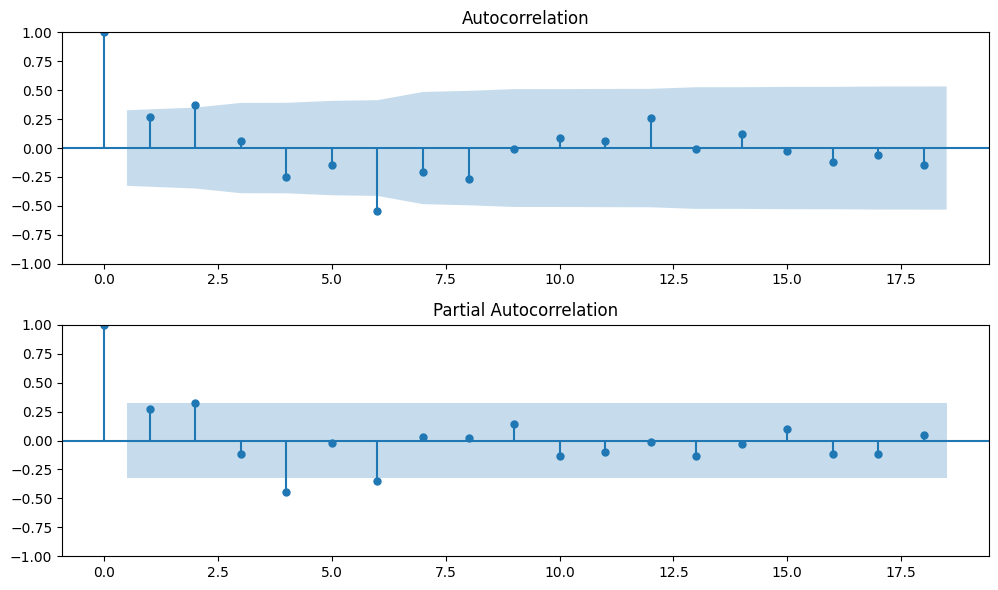

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(filter_data["volume.sales"], model='additive', period=12)

# Create a custom larger figure for the decomposition
fig, axes = plt.subplots(4, 1, figsize=(10, 6))
axes[0].plot(result.observed)
axes[0].set_title('Observed')
axes[1].plot(result.trend)
axes[1].set_title('Trend')
axes[2].plot(result.seasonal)
axes[2].set_title('Seasonal')
axes[3].plot(result.resid)
axes[3].set_title('Residual')
plt.tight_layout()
plt.show()

#ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF in the same figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(filter_data["volume.sales"], lags=18, ax=axes[0])
plot_pacf(filter_data["volume.sales"], lags=18, ax=axes[1])
plt.tight_layout()
plt.show()

##### Now, we're gonna check it with ADF test and KPSS test

In [48]:
# Set date as index
filter_data.set_index("date", inplace=True) 

Test stationarity series original
-------------------------------------
ADF Statistic: -4.065039528699303, p-value: 0.0011057352983620142
KPSS Statistic: 0.07964268328146942, p-value: 0.1

Test stationarity series differenced
-------------------------------------
ADF Statistic: -3.218568123224036, p-value: 0.01893472930292822
KPSS Statistic: 0.08510787636980381, p-value: 0.1

Test stationarity series second differenced
-------------------------------------
ADF Statistic: -2.2842944883516565, p-value: 0.17708335274861436
KPSS Statistic: 0.091038414738134, p-value: 0.1
----------------------------------------------------------------------------------------------------


<Axes: title={'center': 'Diferenciación orden 2'}, xlabel='date'>

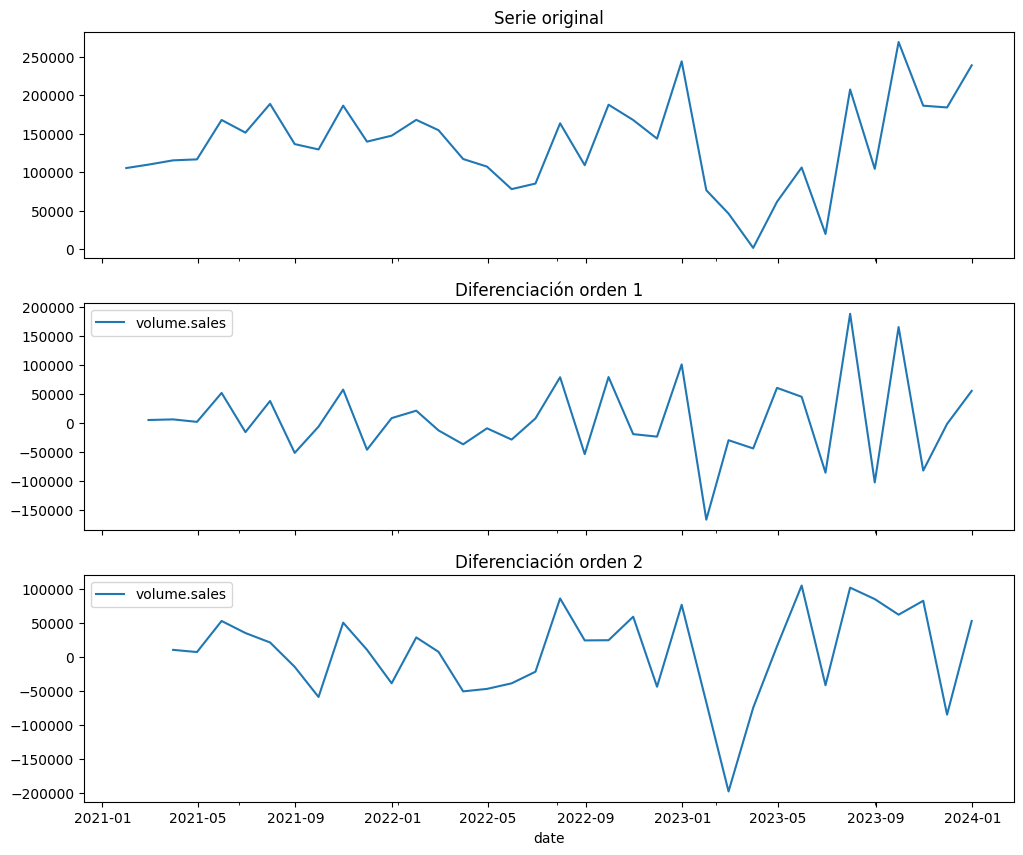

In [49]:
from statsmodels.tsa.stattools import kpss

print("=" * 100)

# Only apply diff() to numeric columns
filter_data_diff = filter_data[['volume.sales']].diff().dropna()
filter_data_diff2 = filter_data[['volume.sales']].diff(periods=2).dropna()

print('Test stationarity series original')
print('-------------------------------------')

adfuller_result = adfuller(filter_data['volume.sales'])
kpss_result = kpss(filter_data['volume.sales'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity series differenced')
print('-------------------------------------')

adfuller_result_diff = adfuller(filter_data_diff['volume.sales'])
kpss_result_diff = kpss(filter_data_diff['volume.sales'])
print(f'ADF Statistic: {adfuller_result_diff[0]}, p-value: {adfuller_result_diff[1]}')
print(f'KPSS Statistic: {kpss_result_diff[0]}, p-value: {kpss_result_diff[1]}')

print('\nTest stationarity series second differenced')
print('-------------------------------------')

adfuller_result_diff2 = adfuller(filter_data_diff2['volume.sales'])
kpss_result_diff2 = kpss(filter_data_diff2['volume.sales'])
print(f'ADF Statistic: {adfuller_result_diff2[0]}, p-value: {adfuller_result_diff2[1]}')
print(f'KPSS Statistic: {kpss_result_diff2[0]}, p-value: {kpss_result_diff2[1]}')

print("-" * 100)
# Gráfico series
# ==============================================================================
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)
filter_data['volume.sales'].plot(ax=axs[0], title='Serie original')
filter_data_diff.plot(ax=axs[1], title='Diferenciación orden 1')
filter_data_diff2.plot(ax=axs[2], title='Diferenciación orden 2')


We see how the ADF test shows a p-value of 0.001, indicating that we can reject the null hypothesis of non-stationarity. So, we can conclude that the time series is stationary.

ADF test: 
- Null hypothesis (H0): it is not stationary.
- Alternative scenario (H1): the series is stationary.
  
The KPSS test shows a statistic of 0.07, which is below the critical value of 0.739 at the 5% significance level. This indicates that we fail to reject the null hypothesis of stationarity. Therefore, we can conclude that the time series is stationary according to the KPSS test as well.

In original data, the p-value of KPSS is 0.1 above the 5% significance level, indicating that we accept the null hypothesis and *is not necessary to difference the series*. Ans it's stationary.

KPSS test: 
- Null hypothesis (H0): the series is stationary
- Alternative scenario (H1): the series is not stationary

**Conclusion: we'll use the parameter d=0 and D=1, cause the series is stationary in the original data and requires seasonal differencing. As we saw in the seasonal decomposition, there is a clear seasonal pattern that needs to be accounted for ARIMA and ARIMAX models.**

### Continuing with ARIMA and ARIMAX models (endogenous), with their respective predictions

statsmodels library

In [50]:
# Model SARIMAX with statsmodels.Sarimax
# ==============================================================================
train_data, test_data = sa.divide_data_for_train_and_test(filter_data)


from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(endog = train_data['volume.sales'], order = (1, 1, 0), seasonal_order = (0, 1, 0, 12))
model_res = model.fit(disp=0)
warnings.filterwarnings("default")
model_res.summary()

# Forecasting
forecast_statsmodel = model_res.get_forecast(steps=len(test_data)).predicted_mean
forecast_statsmodel.name = 'forecast_statsmodel'
display(forecast_statsmodel.head(4))

2023-05-31     15463.761714
2023-06-30     26748.515810
2023-07-31    104010.145038
2023-08-31     49893.945613
Freq: ME, Name: forecast_statsmodel, dtype: float64

Skforecast library

In [51]:
from skforecast.sarimax import Sarimax

warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = Sarimax(order=(1, 1, 0), seasonal_order=(0, 1, 0, 12))
model.fit(y=train_data['volume.sales'])
model.summary()

forecast_skforecast = model.predict(steps=len(test_data))
display(forecast_skforecast.head(4))


/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


,pred
2023-05-31,15463.761714
2023-06-30,26748.515810
2023-07-31,104010.145038
2023-08-31,49893.945613


pdmarima library

In [52]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
from pmdarima import ARIMA
model = ARIMA(order=(1, 1, 0), seasonal_order=(0, 1, 0, 12))
model.fit(y=train_data['volume.sales'])
model.summary()

# Prediction
# ==============================================================================
warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)
forecasting_pdmarima = model.predict(len(test_data))
forecasting_pdmarima.name = 'predicciones_pdmarima'
display(forecasting_pdmarima.head(4))


/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


2023-05-31     2477.740064
2023-06-30     7505.118414
2023-07-31    75889.428584
2023-08-31    13804.232853
Freq: ME, Name: predicciones_pdmarima, dtype: float64

Plot every forecasting in same figure

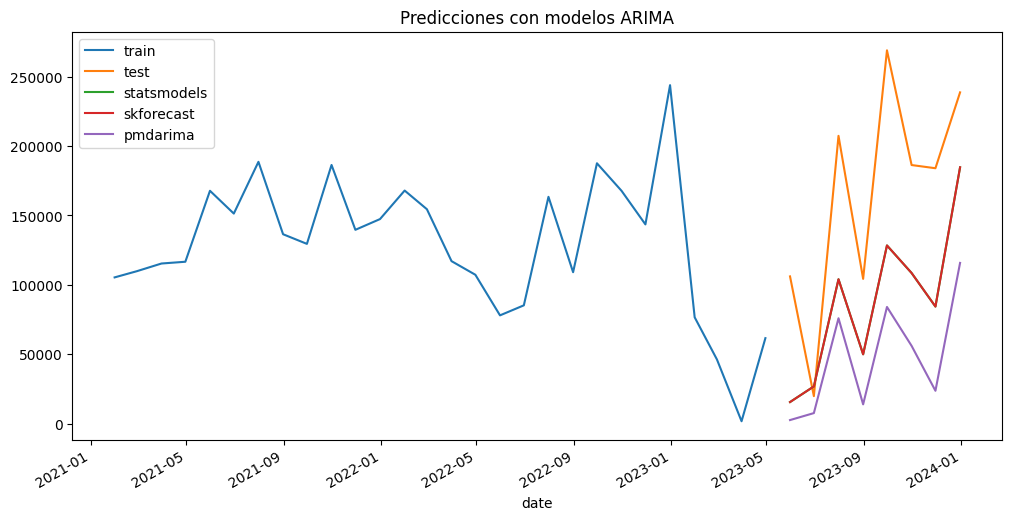

In [53]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
train_data['volume.sales'].plot(ax=ax, label='train')
test_data['volume.sales'].plot(ax=ax, label='test')
forecast_statsmodel.plot(ax=ax, label='statsmodels')
forecast_skforecast.columns = ['skforecast']
forecast_skforecast.plot(ax=ax, label='skforecast')
forecasting_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predicciones con modelos ARIMA')
ax.legend()

### Continuation with models, but taking into account exogenous variables

ARIMAX Models with exogenous variables
Exogenous variables shape - Train: (644, 12), Test: (161, 12)
Exogenous variables: ['supermarket_supermarket-A', 'supermarket_supermarket-B', 'supermarket_supermarket-C', 'supermarket_supermarket-D', 'variant_flavoured', 'variant_light', 'variant_standard', 'variant_vegan', 'packsize_0 - 350 GR', 'packsize_351 - 500 GR', 'packsize_501 - 700 GR', 'packsize_701 - 1000 GR']

Statsmodels SARIMAX with exogenous variables
--------------------------------------------------


644     19976.721428
645     82574.796236
646     56951.337765
647    103205.794831
Name: forecast_statsmodels_exog, dtype: float64


Skforecast SARIMAX with exogenous variables
--------------------------------------------------


,skforecast_exog
644,19976.721428
645,82574.796236
646,56951.337765
647,103205.794831



pmdarima ARIMA with price as exogenous variable
--------------------------------------------------
Comparison of forecasting models:
 Train Data  Test Data  Statsmodels  Statsmodels Exog  Skforecast  Skforecast Exog
  105353.60  106070.50     15463.76          19976.72    15463.76         19976.72
  109828.50   19729.50     26748.52          82574.80    26748.52         82574.80
  115364.40  207420.50    104010.15          56951.34   104010.15         56951.34
  116635.30  104294.50     49893.95         103205.79    49893.95        103205.79


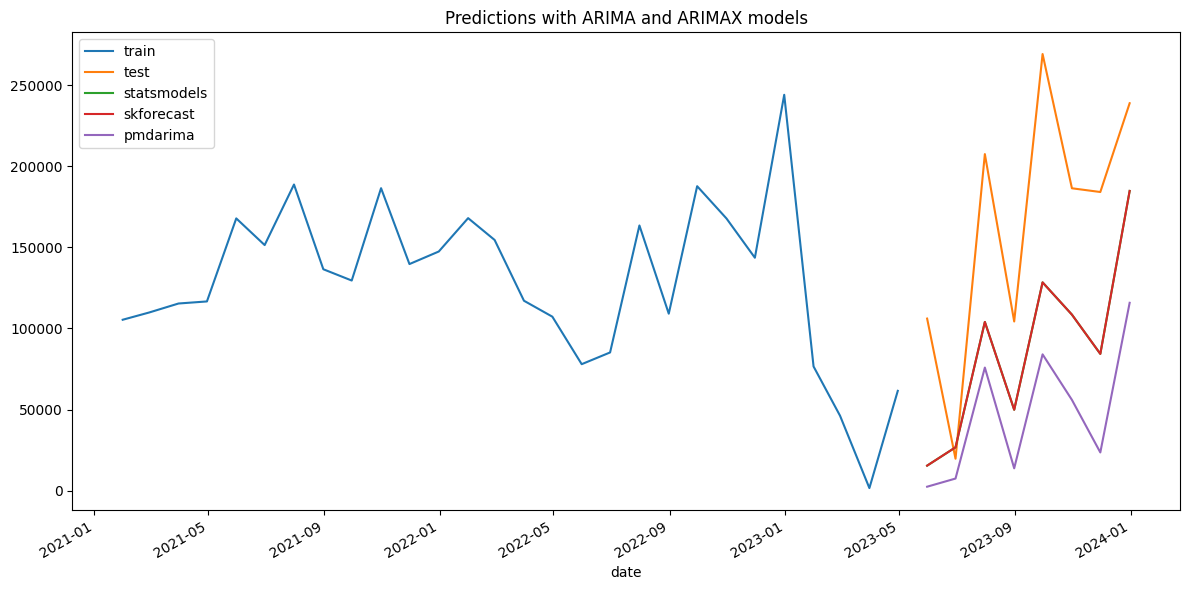

In [54]:
# silent the warnings for the next cells
warnings.filterwarnings("ignore")

# Implementing ARIMAX models with exogenous variables
# ==============================================================================
print("ARIMAX Models with exogenous variables")
print("=" * 100)

# Using supermarket, variant, and pack.size as exogenous variables from filtered data
# First, create dummy variables for categorical features from the filtered data
data_exog = data[['supermarket', 'variant', 'pack.size']]
data_with_dummies = pd.get_dummies(data_exog, prefix=['supermarket', 'variant', 'packsize'])
# Convert boolean dummy variables to integers (0/1) for SARIMAX compatibility
data_with_dummies = data_with_dummies.astype(int)

# Split the data_with_dummies into train and test sets
X_train, X_test = sa.divide_data_for_train_and_test(data_with_dummies)

print(f"Exogenous variables shape - Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Exogenous variables: {list(X_train.columns)}")

# Statsmodels SARIMAX with exogenous variables
print("\nStatsmodels SARIMAX with exogenous variables")
print("-" * 50)
model_exog_statsmodels = SARIMAX(
    endog=data['volume.sales'][:len(X_train)], 
    exog=X_train,
    order=(1, 1, 0), 
    seasonal_order=(0, 1, 0, 12)
)
model_exog_statsmodels_res = model_exog_statsmodels.fit(disp=0)
forecast_exog_statsmodels = model_exog_statsmodels_res.get_forecast(
    steps=len(X_test), 
    exog=X_test
).predicted_mean
forecast_exog_statsmodels.name = 'forecast_statsmodels_exog'
display(forecast_exog_statsmodels.head(4))

# Skforecast SARIMAX with exogenous variables
print("\nSkforecast SARIMAX with exogenous variables")
print("-" * 50)
model_exog_skforecast = Sarimax(order=(1, 1, 0), seasonal_order=(0, 1, 0, 12))
model_exog_skforecast.fit(y=data['volume.sales'][:len(X_train)], exog=X_train)
forecast_exog_skforecast = model_exog_skforecast.predict(steps=len(X_test), exog=X_test)
forecast_exog_skforecast.columns = ['skforecast_exog']
display(forecast_exog_skforecast.head(4))

# Since all exogenous variables are constant (all 1s) for this filtered dataset,
# they don't provide meaningful variation. We'll use price as an exogenous variable instead
print("\npmdarima ARIMA with price as exogenous variable")
print("-" * 50)

# # Use price as exogenous variable
# X_train_price = train_data[['price']]
# X_test_price = test_data[['price']]

# model_exog_pmdarima = ARIMA(order=(1, 1, 0), seasonal_order=(0, 1, 0, 12))
# model_exog_pmdarima.fit(y=data['volume.sales'][:len(X_train)], X=X)
# forecast_exog_pmdarima = model_exog_pmdarima.predict(n_periods=len(X_test), X=X_test_price)
# forecast_exog_pmdarima.name = 'forecast_pmdarima_exog'
# display(forecast_exog_pmdarima.head(4))

# Plot all forecasts including exogenous models
fig, ax = plt.subplots(figsize=(12, 6))
train_data['volume.sales'].plot(ax=ax, label='train')
test_data['volume.sales'].plot(ax=ax, label='test')
forecast_statsmodel.plot(ax=ax, label='statsmodels')
# forecast_exog_statsmodels.plot(ax=ax, label='statsmodels_exog', linestyle='--')
forecast_skforecast.plot(ax=ax, label='skforecast')
# forecast_exog_skforecast.plot(ax=ax, label='skforecast_exog', linestyle='--')
forecasting_pdmarima.plot(ax=ax, label='pmdarima')
# forecast_exog_pmdarima.plot(ax=ax, label='pmdarima_exog', linestyle='--')
ax.set_title('Predictions with ARIMA and ARIMAX models')
ax.legend()
plt.tight_layout()


# See the values instead of the plots
# ==============================================================================
# Create a comparison table
comparison_table = pd.DataFrame({
    'Train Data': train_data['volume.sales'].head(4).values,
    'Test Data': test_data['volume.sales'].head(4).values,
    'Statsmodels': forecast_statsmodel.head(4).values,
    'Statsmodels Exog': forecast_exog_statsmodels.head(4).values,
    'Skforecast': forecast_skforecast.head(4).values.flatten(),
    'Skforecast Exog': forecast_exog_skforecast.head(4).values.flatten()
})

print("Comparison of forecasting models:")
print("=" * 80)
print(comparison_table.to_string(index=False, float_format='%.2f'))



Doing with GPT help

In [ ]:
TARGET_COL = "volume.sales"
SELECT_SERIES = None   
KEYS = ["supermarket","variant","pack.size"]

def adf_d(s):
    s = s.dropna()
    if len(s) < 6 or s.nunique() < 4:
        return 0
    try:
        _, pval, *_ = adfuller(s, autolag="AIC")
        return 0 if pval < 0.05 else 1
    except Exception:
        return 1
    
d = adf_d(train[TARGET_COL].astype(float))

In [ ]:
from sklearn.preprocessing import OneHotEncoder

y = data['volume.sales']
encoder = OneHotEncoder(drop="first", sparse_output=False)

X_cat = encoder.fit_transform(data[["supermarket","variant", "pack.size"]])

X = pd.DataFrame(X_cat, index=data.index, columns=encoder.get_feature_names_out(["supermarket","variant", "pack.size"]))

train_size = int(len(data) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

model = SARIMAX(y_train, exog=X_train, order=(1,1,0), seasonal_order=(0,1,0,12))
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       volume.sales   No. Observations:                  644
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -7742.674
Date:                            Mon, 08 Sep 2025   AIC                          15507.348
Time:                                    12:22:37   BIC                          15556.268
Sample:                                         0   HQIC                         15526.348
                                            - 644                                         
Covariance Type:                              opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
supermarket_supermarket-B -2.002e+04   3828.321     -5.228      0.000   -2.75e+04   

/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
# evaluate the model with forecasting
y_forecast = results.get_forecast(steps=len(y_test), exog=X_test).predicted_mean

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_forecast)
mae = mean_absolute_error(y_test, y_forecast)
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")

# Comparar valores reales vs predichos
comparison_results = pd.DataFrame({
	'Real': y_test.values, 
	'Predicho': y_forecast.values
})
print(comparison_results.head())


MSE: 37116928313.51, MAE: 164720.93
         Real       Predicho
0    9809.650   20019.361157
1    2194.640   82575.263114
2     126.756   56983.087956
3  114778.590  103216.917830
4   94810.450  119418.000377


/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/oscarjimenezbou/Documents/TFG_ADE/code/TFG/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
